In [1]:
import os
import sys
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

from ensemble_seg import merge_masks

In [2]:
coco_data = json.load(open('coco.json'))
    
frame = cv2.imread('frame.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

results = []

for annotation in coco_data['annotations']:
    mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
    contour = np.array(annotation['segmentation']).reshape(-1, 2).astype(np.int32)
    cv2.fillPoly(mask, [contour], 255)
    bbox = annotation['bbox']
    results.append({ 'mask': mask, 'bbox': bbox, 'confidence': 1.0 })
    
original_visual = frame.copy()
for result in results:
    mask = result['mask'].copy()
    
    contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA)
    
    color = [np.random.randint(0, 255) for _ in range(3)]
    
    mask[:, :, 1] = 0
    mask[:, :, 2] = 0
    mask[:, :, 3] = color[2]

    original_visual = cv2.addWeighted(original_visual, 1, mask, 0.3, 0)
    original_visual = cv2.drawContours(original_visual, [contour], -1, (*color, 255), 10)

    x, y, w, h = cv2.boundingRect(contour)
    original_visual = cv2.rectangle(original_visual, (x, y), (x + w, y + h), (*color, 255), 10)

Merge Group: (3, 4)
Merge Group: (8,)
Merge Group: (5, 6, 7)
Merge Group: (10,)
Merge Group: (0, 1, 2)
Merge Group: (9,)


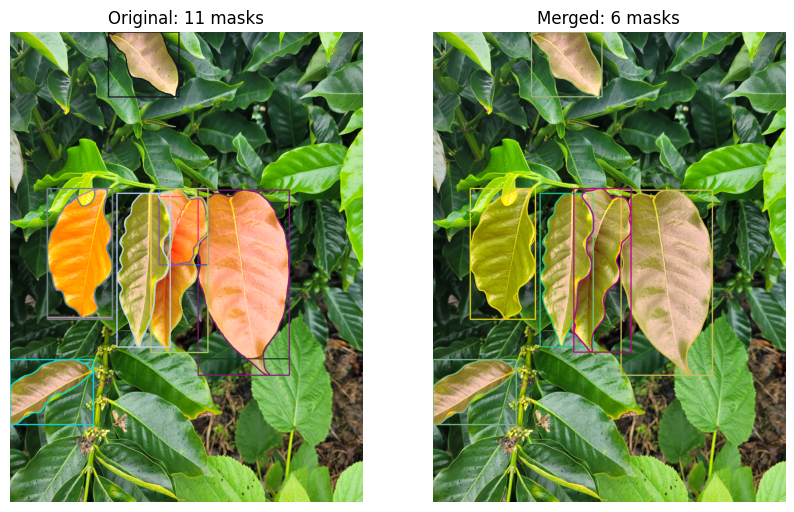

In [6]:
visual = frame.copy()

groups = list(merge_masks(results, area_diff_percent=0.8, iou_threshold=0.3))

total_masks = len(results)
total_new_masks = len(groups)

for group, mask in groups:
    
    print(f'Merge Group: {group}')
    
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA)
    
    color = [np.random.randint(0, 255) for _ in range(3)]
    
    mask[:, :, 1] = 0
    mask[:, :, 2] = 0
    mask[:, :, 3] = color[2]

    visual = cv2.addWeighted(visual, 1, mask, 0.3, 0)
    visual = cv2.drawContours(visual, contours, -1, (*color, 255), 10)
    
    # draw bounding box
    x, y, w, h = cv2.boundingRect(contours[0])
    visual = cv2.rectangle(visual, (x, y), (x + w, y + h), (*color, 255), 10)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title(f'Original: {total_masks} masks')
plt.axis('off')
plt.imshow(original_visual)
plt.subplot(1, 2, 2)
plt.title(f'Merged: {total_new_masks} masks')
plt.axis('off')
plt.imshow(visual)
plt.show()